## 유전알고리즘(Genetic Algorithm)을 활용한 Feature Selection 예제 코드

- Data: 이진 분류
- 370개의 피처로 이루어진 데이터 세트 기반에서 고객만족 여부를 예측하는 것
- 피처이름은 모두 익명화되어 있어 어떤 속성인지는 알 수 없음

In [1]:
import os
import random

import numpy as np
import pandas as pd
import datetime

from model.train_module import TrainClassifier
from hyperopt import hp

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore")

pd.set_option('display.max_row', 50)
pd.set_option('display.max_column', None)

## Load Data

In [2]:
trainData = pd.read_csv('data/train.csv')
testData = pd.read_csv('data/test.csv')

print('===== Train Data: {} ====='.format(trainData.shape))
print(trainData.head(5))
print('===== Test Data: {} ====='.format(testData.shape))
print(testData.head(5))


===== Train Data: (76020, 371) =====
   ID  var3  var15  imp_ent_var16_ult1  imp_op_var39_comer_ult1  \
0   1     2     23                 0.0                      0.0   
1   3     2     34                 0.0                      0.0   
2   4     2     23                 0.0                      0.0   
3   8     2     37                 0.0                    195.0   
4  10     2     39                 0.0                      0.0   

   imp_op_var39_comer_ult3  imp_op_var40_comer_ult1  imp_op_var40_comer_ult3  \
0                      0.0                      0.0                      0.0   
1                      0.0                      0.0                      0.0   
2                      0.0                      0.0                      0.0   
3                    195.0                      0.0                      0.0   
4                      0.0                      0.0                      0.0   

   imp_op_var40_efect_ult1  imp_op_var40_efect_ult3  imp_op_var40_ult1  \
0    

In [3]:
## Y변수
TARGET_NM = 'TARGET'
## X변수 리스트
featureList = list(set(trainData.columns) - set(['ID', TARGET_NM]))
## Sedd
SEED_NUM = 1000

# Train / Valid(8:2) 분할

In [4]:
(
    trainX, 
    validX, 
    trainY, 
    validY
) = train_test_split(
    trainData[featureList], 
    trainData[TARGET_NM], 
    test_size = 0.2, 
    random_state = 1000,
    stratify = trainData[TARGET_NM],
    shuffle = True
)

print('Train Data: {}'.format(trainX.shape))
print('Valid Data: {}'.format(validX.shape), '\n')

print('Target Value(TrainX) Count')
print(trainY.value_counts())


Train Data: (60816, 369)
Valid Data: (15204, 369) 

Target Value(TrainX) Count
TARGET
0    58410
1     2406
Name: count, dtype: int64


# 학습 모듈 선언
- Scale(MinMax 0~1으로 변환) 수행
- SMOTE(Upsampling일종) 수행

In [52]:
## Seed 고정
SEED_NUM = 1000
## 학습모듈 선언
TrainModule = TrainClassifier(
    train_data = pd.concat([trainX, trainY], axis = 1),
    test_data = pd.concat([validX, validY], axis = 1),
    feature_ls = featureList,
    target_nm = TARGET_NM,
    scale_flag = True,
    smote_flag = True,
    core_cnt = -1,
    seed = SEED_NUM,
    verbose = True,
)

Scaled Train Info
       ind_var27_0  num_reemb_var17_hace3  saldo_medio_var12_hace2  \
count      60816.0                60816.0             60816.000000   
mean           0.0                    0.0                 0.001300   
std            0.0                    0.0                 0.012059   
min            0.0                    0.0                 0.000000   
25%            0.0                    0.0                 0.000000   
50%            0.0                    0.0                 0.000000   
75%            0.0                    0.0                 0.000000   
max            0.0                    0.0                 1.000000   

          ind_var17  num_var28_0  ind_var46  imp_op_var39_efect_ult1  \
count  60816.000000      60816.0    60816.0             60816.000000   
mean       0.001562          0.0        0.0                 0.001506   
std        0.039493          0.0        0.0                 0.012342   
min        0.000000          0.0        0.0                 0.0

# 변수선택1 - Random Feature
- 난수로 생성한 임의변수들보다 변수중요도가 낮은 변수들을 제거하는 알고리즘
- Boruta 알고리즘과 유사함
- Boruta과 차이점은, Boruta은 기존 변수 각각을 임의로 섞은 변수를 생성한 후 변수중요도를 구하는 것이고
- 해당 로직은 임의의 난수로 생성한 랜덤 변수를 여러 개 생성한 후 변수중요도를 계산하는 것

In [8]:
%%time

## 임의로 생성한 Random변수들보다 변수중요도가 떨어지는 변수들을 제거하는 로직
feat_RandSelct_LS = fnFeatSelect_RandVar(
    df_x = TrainModule.train_data[TrainModule.feature_ls], 
    df_y = TrainModule.train_data[TrainModule.target_nm], 
    x_var = TrainModule.feature_ls, 
    core_cnt = -1,
    rand_num = 50, 
    threshold = 0.000,
    n_estimators = 3000,
    seed = self.seed
)
deleteFeatureLS = list(set(TrainModule.feature_ls) - set(feat_RandSelct_LS))
print('Feauter List with Rand-Select({}): {}'.format(len(feat_RandSelct_LS), feat_RandSelct_LS))

if len(deleteFeatureLS) > 0:
    print('Delete Feature List({}): {}'.format(len(deleteFeatureLS), deleteFeatureLS))


Feauter List with Rand-Select(27): ['ind_var30', 'ind_var5', 'num_med_var22_ult3', 'num_med_var45_ult3', 'num_meses_var5_ult3', 'num_var22_hace2', 'num_var22_hace3', 'num_var22_ult1', 'num_var22_ult3', 'num_var30', 'num_var35', 'num_var4', 'num_var42', 'num_var45_hace2', 'num_var45_hace3', 'num_var45_ult1', 'num_var45_ult3', 'num_var5', 'saldo_medio_var5_hace2', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'saldo_var30', 'saldo_var42', 'saldo_var5', 'var15', 'var36', 'var38']
Delete Feature List(342): ['ind_var27_0', 'num_reemb_var17_hace3', 'saldo_medio_var12_hace2', 'ind_var17', 'num_var28_0', 'ind_var46', 'imp_op_var39_efect_ult1', 'num_var20', 'saldo_var37', 'delta_imp_trasp_var17_out_1y3', 'num_op_var40_ult1', 'ind_var18_0', 'num_var30_0', 'num_venta_var44_hace3', 'num_var13_0', 'num_var44_0', 'saldo_medio_var8_hace2', 'ind_var13_0', 'delta_imp_compra_var44_1y3', 'imp_aport_var33_hace3', 'saldo_medio_var17_ult3', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'ind_var1

# 변수선택2 - 유전 알고리즘
- 최적화 알고리즘 하나인 유전 알고리즘을 활용하여 변수선택을 수행

In [10]:
%%time

## 모델 선언
model_instance = RandomForestClassifier(random_state = SEED_NUM, n_jobs = -1)
## 변수 선택(유전 알고리즘)
(
    feat_Genetic_LS, 
    geneticScoreList, 
    geneticFeatList_PerGeneration
) = fnFeatSelect_GeneticAlgo(
    n = 10,
    feat_num = len(feat_RandSelct_LS),
    select_sol_num = 5,
    p = 0.3,
    q = 0.2,
    num_generation = 100,
    x_df = TrainModule.train_data[feat_RandSelct_LS],
    y = TrainModule.train_data[self.target_nm],
    model_instance = model_instance,
    cv_num = 2,
    scoring = 'neg_log_loss',
    seed = SEED_NUM
)
deleteGeneticFeatureLS = list(set(feat_RandSelct_LS) - set(feat_Genetic_LS))
print('Feauter List with Genetic Algorithm({}): {}'.format(len(feat_Genetic_LS), feat_Genetic_LS))

if len(deleteFeatureLS) > 0:
    print('Delete Feature List({}): {}'.format(len(deleteGeneticFeatureLS), deleteGeneticFeatureLS))

Genetic Algorithm for Feature Selection is Start


Genetic Algorithm Score: "-0.28385923876206226":   2%|          | 2/100 [00:51<45:33, 27.89s/it]

2/100: Feature Selection!(Count: 17)


Genetic Algorithm Score: "-0.28360508858530437":   4%|          | 4/100 [02:57<1:25:00, 53.13s/it]

4/100: Feature Selection!(Count: 17)


Genetic Algorithm Score: "-0.2836050885853043":   5%|          | 5/100 [04:13<1:36:57, 61.24s/it] 

5/100: Feature Selection!(Count: 17)


Genetic Algorithm Score: "-0.278733055930838":   6%|          | 6/100 [05:22<1:40:12, 63.97s/it] 

6/100: Feature Selection!(Count: 20)


Genetic Algorithm Score: "-0.2750409843896524":  12%|=         | 12/100 [12:10<1:40:45, 68.70s/it]

12/100: Feature Selection!(Count: 14)


Genetic Algorithm Score: "-0.2750409843896524": 100%|==========| 100/100 [1:43:52<00:00, 62.32s/it]

Genetic Algorithm for Feature Selection Elapsed Time: 103.87 Minutes
Feauter List with Genetic Algorithm(14): ['num_med_var22_ult3', 'num_meses_var5_ult3', 'num_var22_hace3', 'num_var22_ult3', 'num_var35', 'num_var4', 'num_var42', 'num_var45_hace2', 'num_var45_hace3', 'num_var5', 'saldo_medio_var5_hace2', 'saldo_var30', 'var15', 'var36']
Delete Feature List(13): ['saldo_medio_var5_ult1', 'saldo_var42', 'saldo_var5', 'num_var22_ult1', 'var38', 'saldo_medio_var5_ult3', 'num_var30', 'num_var22_hace2', 'ind_var30', 'num_med_var45_ult3', 'num_var45_ult3', 'num_var45_ult1', 'ind_var5']
CPU times: total: 16h 5min 4s
Wall time: 1h 43min 52s


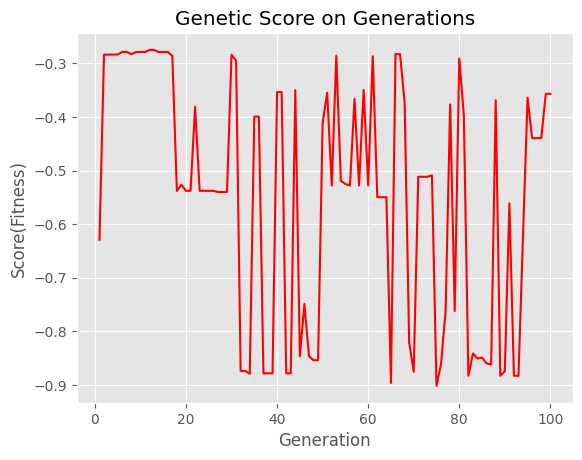

In [12]:
plt.style.use('ggplot')

plt.figure()
plt.plot(
    np.arange(1, len(geneticScoreList) + 1),
    geneticScoreList,
    color = 'red'
)
plt.xlabel('Generation')
plt.ylabel('Score(Fitness)')
plt.title('Genetic Score on Generations')

plt.show()

# 최종 모델 학습

Optimizing Hyper-Para(XGB) is Start
100%|██████████| 50/50 [26:59<00:00, 32.40s/trial, best loss: 0.25207568568059546]
Optimizing L1, L2 Regularization
.. Start: L1(reg_alpha)
.. Start: L2(reg_lambda)
Optimizing Number of Estimators & Learning Rate
Best Para(XGB): colsample_bytree: 0.74, gamma: 0.04, max_depth: 31, min_child_weight: 0.31735023563467823, subsample: 0.69, learning_rate: 0.01, n_estimators: 760, reg_alpha: 0.0001, reg_lambda: 1e-05
Optimizing Hyper-Para(XGB) Elapsed Time: 52.57 Minutes


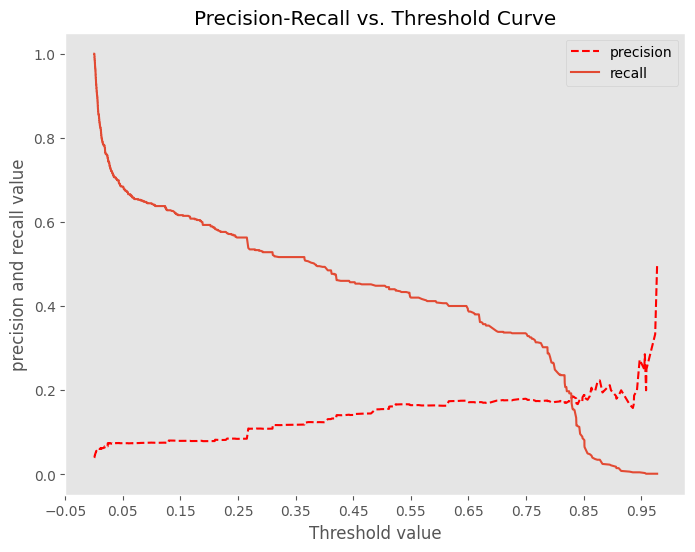

Cut-off Value(Optimizing): 0.8291510343551636


In [53]:
## 최종 변수List Redefine
TrainModule.fnRedefinFeatureList(feat_Genetic_LS)

## 예측모델 선택
MODEL_NM = 'xgb'
## Hyper-parameter Space
H_PARA_SPACE = {
    'rf': {
        'max_depth': hp.uniform("max_depth", 2, 50),
        'min_samples_leaf': hp.uniform("min_samples_leaf", 2, 30),
        'min_samples_split': hp.uniform("min_samples_split", 2, 30),
        'max_features': hp.uniform("max_features", 2, int(len(TrainModule.feature_ls) * 0.8))
    },
    'xgb': {
        'max_depth': hp.uniform("max_depth", 2, 50),
        'min_child_weight': hp.loguniform('min_child_weight', -3, 3),
        'subsample': hp.uniform('subsample', 0.3, 0.8),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 0.8),
        'gamma': hp.loguniform('gamma', -10, 10)
    },
    'lgbm': {
        'max_depth': hp.uniform("max_depth", 2, 50),
        'min_child_weight': hp.loguniform('min_child_weight', -3, 3),
        'subsample': hp.uniform('subsample', 0.3, 0.8),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.8),
        'num_leaves': hp.uniform('num_leaves', 5, 30)
    }
}

## 예측모델 학습
TrainModule.fnFit(
    model_nm = MODEL_NM,
    para_tune_flag = True,
    para_space = H_PARA_SPACE,
    learing_rate_ls = [0.001, 0.01, 0.1],
    cut_off = None,
    max_evals = 50,
    cv_num = 3,
)
## 최종 Hyper-parameter
bestPara = TrainModule.best_para
## Cutoff Value
CUTOFF_VALUE = TrainModule.cut_off
## 최종 변수 리스트
featureFinalList = TrainModule.feature_ls

# 예측
- 검증(Valid) Data에 적용하여 예측모델의 성능을 확인

Score List
   ACCURACY  PRECISSION    RECALL  F1_SCORE
0  0.937056    0.182469  0.169435  0.175711 

Confusion Matrix
[[14145   457]
 [  500   102]] 

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     14602
           1       0.18      0.17      0.18       602

    accuracy                           0.94     15204
   macro avg       0.57      0.57      0.57     15204
weighted avg       0.93      0.94      0.94     15204



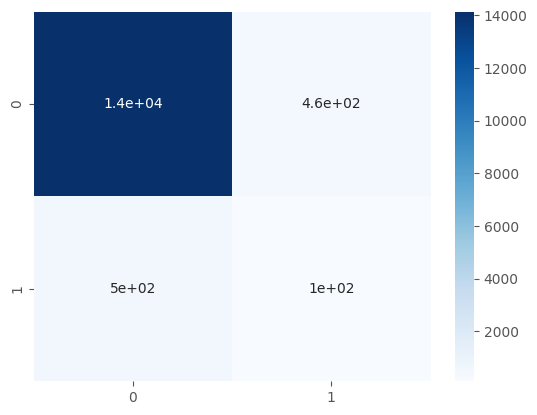

In [58]:
## Predict
predict_Valid_Value = TrainModule.fnPredict(
    model = TrainModule.model,
    test_data = TrainModule.test_data,
    feature_ls = featureFinalList,
    target_nm = TARGET_NM,
    cut_off = CUTOFF_VALUE
)

## Score
predict_Valid_Score = TrainModule.fnScoreResult(
    y_value = TrainModule.test_data[TARGET_NM],
    predict_value = predict_Valid_Value,
    verbose = True
)

# 최종 예측
- Test Data에 적용하기 위함
- 학습 Data 전체로 학습한 후, 위에 검증 단계에서 최적값을 도출한 변수 리스트, Hyper-parameter, Cut-off 값을 사용

In [ ]:
## 최종 학습모듈 선언
TrainModule_Final = TrainClassifier(
    train_data = trainData[featureFinalList + [TARGET_NM]],
    test_data = testData[featureFinalList],
    feature_ls = featureFinalList,
    target_nm = TARGET_NM,
    scale_flag = True,
    smote_flag = True,
    core_cnt = -1,
    seed = SEED_NUM,
    verbose = True,
)

## 최종 예측모델 학습
TrainModule_Final.fnFit(
    model_nm = MODEL_NM,
    para_tune_flag = False,
    para_space = bestPara,
    cut_off = CUTOFF_VALUE
)

## Predict
predict_Test_Value = TrainModule_Final.fnPredict(
    model = TrainModule_Final.model,
    test_data = TrainModule_Final.test_data,
    feature_ls = TrainModule_Final.feature_ls,
    target_nm = TrainModule_Final.target_nm,
    cut_off = TrainModule_Final.cut_off
)


In [ ]:
## Load submission File
submissionFile = pd.read_csv('data/sample_submission.csv')
submissionFile[TARGET_NM] = predict_Test_Value